In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

In [2]:
import theano
import theano.tensor as T

import numpy as np
import pymc3 as pm
from scipy import stats

import matplotlib.pyplot as plt

In [3]:
data = np.concatenate((stats.norm.rvs(0, 2, size=80), 
                       stats.norm.rvs(14, 1,size=50), 
                       stats.norm.rvs(16, 1, size=50)))

np.random.shuffle(data)

if data.ndim == 1: N = len(data)
else: N, shape = data.shape

max_tables = 20
data_range = np.linspace(-5, 20, 180)

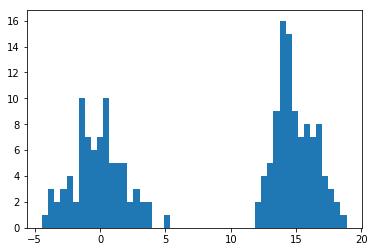

In [4]:
_ = plt.hist(data, bins=50)
plt.show()

## Dirichlet Process Mixtures

In [5]:
def stick_breaking(beta):
    portion_remaining = T.concatenate([[1], T.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [6]:
with pm.Model() as model1:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=max_tables)
    theta = pm.Deterministic('theta', stick_breaking(beta))

    tau = pm.Gamma('tau', 1., 1., shape=max_tables)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=max_tables)
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=max_tables)
    pm.NormalMixture('X', theta, mu, tau=lambda_ * tau, observed=data)

In [7]:
for RV in model1.basic_RVs:
    print(RV.name, RV.logp(model1.test_point))

alpha_log__ -1.0
beta_logodds__ -69.31471805599446
tau_log__ -50.0
lambda_interval__ -69.31471805599446
mu -23.039658363379786
X -28763.21018163224


In [8]:
with model1:
    trace = pm.sample(1000, init='advi', nuts_kwargs=dict(target_accept=.9))

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 564.74:  45%|████▍     | 89375/200000 [01:22<01:41, 1088.74it/s] 
Convergence achieved at 89400
Interrupted at 89,399 [44%]: Average Loss = 885.11
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:44<00:00, 14.17draws/s]
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


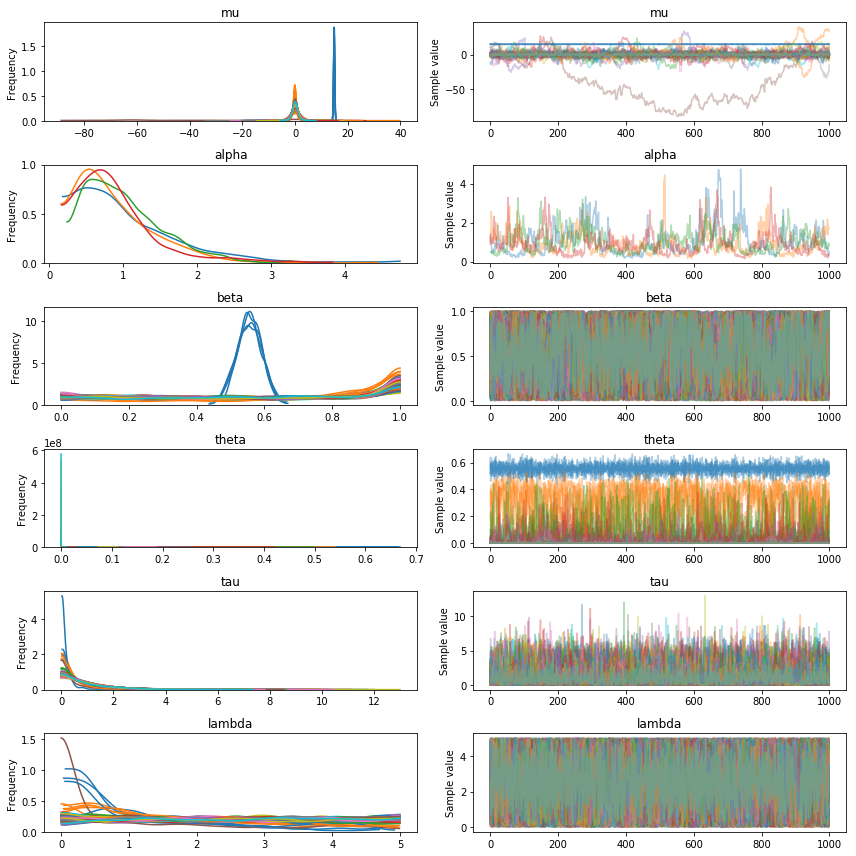

In [9]:
_ = pm.traceplot(trace)

In [10]:
post_pdf_contribs = stats.norm.pdf(np.atleast_3d(data_range),
                                      trace['mu'][:, np.newaxis, :],
                                      1. / np.sqrt(trace['lambda'] * trace['tau'])[:, np.newaxis, :])
post_pdfs = (trace['theta'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)

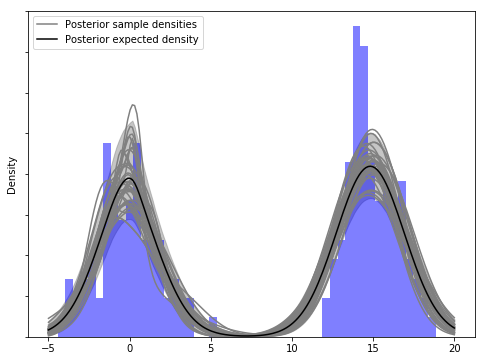

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 50
ax.hist(data, bins=n_bins, normed=True,
        lw=0, alpha=0.5)

ax.fill_between(data_range, post_pdf_low, post_pdf_high,
                color='gray', alpha=0.45)
ax.plot(data_range, post_pdfs[0],
        c='gray', label='Posterior sample densities')
ax.plot(data_range, post_pdfs[::100].T, c='gray')
ax.plot(data_range, post_pdfs.mean(axis=0),
        c='k', label='Posterior expected density')

ax.set_yticklabels([])
ax.set_ylabel('Density')
ax.legend(loc=2)

plt.show()

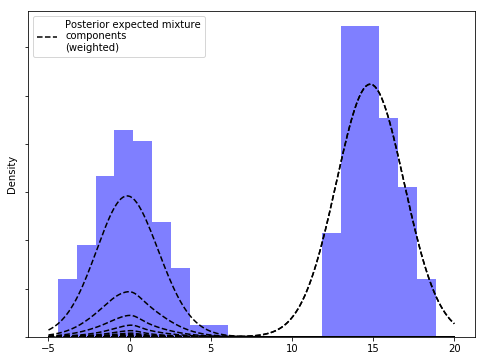

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(data, bins=n_bins, normed=True,
        lw=0, alpha=0.5)

ax.plot(data_range, (trace['theta'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0)[:, 0],
        '--', c='k', label='Posterior expected mixture\ncomponents\n(weighted)')
ax.plot(data_range, (trace['theta'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0),
        '--', c='k')

ax.set_yticklabels([])
ax.set_ylabel('Density')
ax.legend(loc=2)

plt.show()

## Chinese Restaurant Process Clustering
#### Using Pólya's urn scheme

In [14]:
class CRPClustering(object):
    def __init__(self, size):
        self.size = size
        self.n_tables = 0
        self.table_assignments = T.zeros(size, dtype=int)
        self.p0 = np.random.random(self.size)
    
    def chinese_restaurant_process(self, alpha, max_tables=10):
        if self.size < 1: return None
        
        for customer in range(self.size):            
            if 1. * alpha / (alpha + customer) > self.p0[customer]:
                self.table_assignments = self.choose_unoccupied(customer)
            else:
                self.table_assignments = self.choose_occupied(customer)
        
        return T.extra_ops.to_one_hot(self.table_assignments, max_tables)
    
    def choose_unoccupied(self, customer):
        self.n_tables += 1
        return T.set_subtensor(self.table_assignments[customer], self.n_tables - 1)

    def choose_occupied(self, customer):
        p = np.unique(self.table_assignments[:customer].eval(), return_counts=True)[1] / customer
        random_assignment = np.random.choice(self.n_tables, p=p)
        return T.set_subtensor(self.table_assignments[customer], random_assignment)

chinese_restaurant_process = CRPClustering(size=N).chinese_restaurant_process

In [15]:
with pm.Model() as model2:
    # alpha = pm.Gamma('alpha', alpha=1., beta=.5)
    pi = pm.Deterministic('pi', chinese_restaurant_process(1., max_tables))
    
    tau = pm.Gamma('tau', 1., 1., shape=max_tables)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=max_tables)
    mu = pm.Normal('mu', 0., tau=lambda_ * tau, shape=max_tables)
    
    pm.NormalMixture('X', pi, mu, tau=lambda_ * tau, observed=data)

In [16]:
for RV in model2.basic_RVs:
    print(RV.name, RV.logp(model2.test_point))

tau_log__ -50.0
lambda_interval__ -69.31471805599446
mu -23.039658363379786
X -28763.21018163224


In [17]:
with model2:
    trace = pm.sample(1000, init='advi', nuts_kwargs=dict(target_accept=.9))

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 686.26:  21%|██        | 42001/200000 [00:36<02:19, 1132.19it/s]
Convergence achieved at 42100
Interrupted at 42,099 [21%]: Average Loss = 2,441.3
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau]
Sampling 4 chains: 100%|██████████| 6000/6000 [02:16<00:00, 44.05draws/s]
The number of effective samples is smaller than 10% for some parameters.


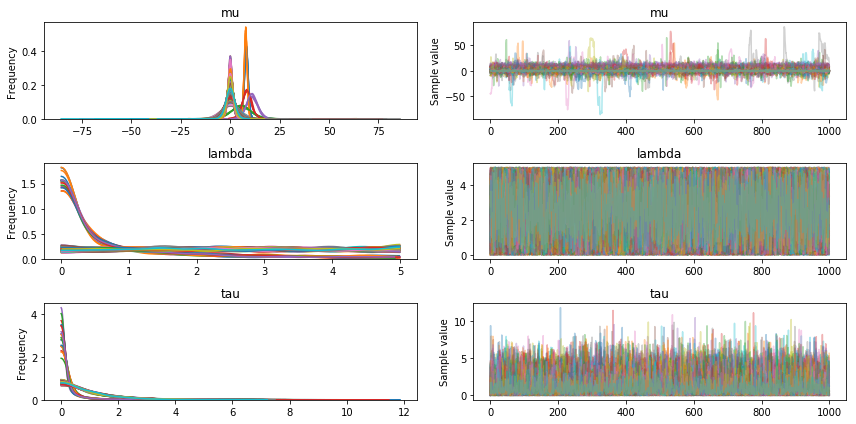

In [18]:
_ = pm.traceplot(trace, varnames=['mu', 'lambda', 'tau'])

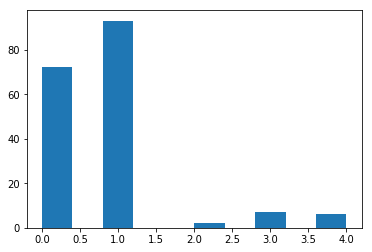

In [19]:
_ = plt.hist(np.argmax(trace['pi'], axis=-1).mean(axis=0))
plt.show()

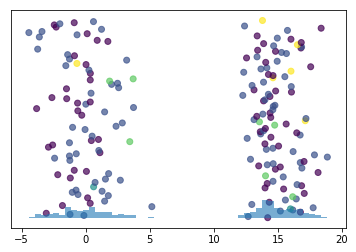

In [20]:
_ = plt.hist(data, bins=50, alpha=.6)

plt.scatter(data, y=np.arange(len(data)), 
            c=np.argmax(trace['pi'], axis=-1).mean(axis=0), 
            alpha=.7)

plt.yticks([])
plt.show()